### Graph Mining

In [1]:
# Loading the datasets 
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain
import pandas as pd
import networkx as nx
from sklearn.cluster import SpectralClustering
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Load the datasets
restaraunts = pd.read_csv('../data/clean/restaraunts.csv', usecols=lambda column: column not in ['Unnamed: 0'])
rest_labels = pd.read_csv('../data/clean/rest_labels.csv', usecols=lambda column: column not in ['Unnamed: 0'])
users = pd.read_csv('../data/clean/users.csv', usecols=lambda column: column not in ['Unnamed: 0'])
ratings = pd.read_csv('../data/clean/ratings.csv', usecols=lambda column: column not in ['Unnamed: 0'])

In [4]:
# Joining the cleaned restaraunts data with cluster labels 
restaraunts_labels = pd.merge(restaraunts, rest_labels, on='placeID', how='left')
restaraunts_labels.head(5)

,placeID,latitude,longitude,name,state,alcohol,smoking_area,dress_code,accessibility,price,Rambience,franchise,area,other_services,Rcuisine_str,Rpayment_str,parking_lot_str,cluster
0,134999,18.915421,-99.184871,Kiku Cuernavaca,Morelos,No_alcohol_served,NaN,Informal,No_accessibility,Medium,Familiar,F,Closed,NaN,Japanese,Unknown,NaN,2
1,132825,22.147392,-100.983092,puesto de tacos,San Luis Potosi,No_alcohol_served,NaN,Informal,Completely,Low,Familiar,F,Open,NaN,Mexican,Cash,NaN,0
2,135106,22.149709,-100.976093,El Rincón de San Francisco,San Luis Potosi,Wine-beer,Only at bar,Informal,Partially,Medium,Familiar,F,Open,NaN,Mexican,"Cash, visa, mastercard-eurocard",NaN,2
3,132667,23.752697,-99.163359,little pizza Emilio Portes Gil,Tamaulipas,No_alcohol_served,NaN,Informal,Completely,Low,Familiar,T,Closed,NaN,Armenian,Cash,NaN,0
4,132613,23.752903,-99.165076,carnitas_mata,Tamaulipas,No_alcohol_served,Permitted,Informal,Completely,Medium,Familiar,T,Closed,NaN,Mexican,Cash,Yes,1


In [5]:
# Inspecting the datasets again
print("Restaraunts---")
print(restaraunts_labels.columns)
print("Users---")
print(users.columns)
print("Ratings---")
print(ratings.columns)

Restaraunts---
Index(['placeID', 'latitude', 'longitude', 'name', 'state', 'alcohol',
       'smoking_area', 'dress_code', 'accessibility', 'price', 'Rambience',
       'franchise', 'area', 'other_services', 'Rcuisine_str', 'Rpayment_str',
       'parking_lot_str', 'cluster'],
      dtype='object')
Users---
Index(['userID', 'latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
       'birth_year', 'interest', 'personality', 'religion', 'activity',
       'color', 'weight', 'budget', 'height', 'Rcuisine_str', 'Upayment_str'],
      dtype='object')
Ratings---
Index(['userID', 'placeID', 'rating', 'food_rating', 'service_rating'], dtype='object')


In [6]:
## Removing the bias attributes like color, weight, height & religion 
columns = ['userID','latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
       'birth_year', 'interest', 'personality', 'activity',
        'budget', 'Rcuisine_str', 'Upayment_str']
users = users[columns]

In [7]:
# Making age group column from birth year
current_year = datetime.now().year
users['age'] = current_year - users['birth_year']

# Redefine new age bins and labels for categorization
bins = [0, 18, 25, 35, 50, 100]  # Example adjustment
labels = ['Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']

# Recategorize age into the new groups
users['age_group'] = pd.cut(users['age'], bins=bins, labels=labels, right=False)

# Drop the 'birth_year' and 'age' columns if they are no longer needed
users.drop(['birth_year', 'age'], axis=1, inplace=True)

In [8]:
# Comprehensive normalization map based on unique cuisines found
# This maps less common or specific cuisines to broader categories
# Create the 'cuisine_list' column by splitting 'Rcuisine_str' into lists
users['cuisine_list'] = users['Rcuisine_str'].str.split(', ')

# Explode the 'cuisine_list' to normalize and separate cuisines into individual rows
exploded_users = users.explode('cuisine_list')

normalization_map = {
    'American': 'North American', 'Mexican': 'Latin American', 'Pizzeria': 'Italian', 
    'Bar': 'Bar & Grill', 'Japanese': 'Asian', 'Seafood': 'Seafood', 'Fast_food': 'Fast Food',
    'International': 'International', 'Italian': 'Italian', 'Cafeteria': 'Casual Dining', 
    'Burgers': 'Fast Food', 'Chinese': 'Asian', 'Dutch-belgian': 'European', 'Greek': 'Mediterranean',
    'Moroccan': 'African', 'Pacific_northwest': 'American', 'Caribbean': 'Caribbean',
    'Cafe-coffee_shop': 'Cafe', 'Scandinavian': 'European', 'African': 'African',
    'Dessert-ice_cream': 'Desserts', 'Australian': 'Australian', 'Hungarian': 'European',
    'Russian-ukrainian': 'Eastern European', 'Tibetan': 'Asian', 'Persian': 'Middle Eastern',
    'Romanian': 'Eastern European', 'Polish': 'Eastern European', 'Barbecue': 'American',
    'Organic-healthy': 'Healthy', 'North_african': 'African', 'Thai': 'Asian', 'Chilean': 'Latin American',
    'Vietnamese': 'Asian', 'Burmese': 'Asian', 'Hot_dogs': 'Fast Food', 'Peruvian': 'Latin American',
    'Southern': 'American', 'Indonesian': 'Asian', 'Polynesian': 'Polynesian', 'Middle_eastern': 'Middle Eastern',
    'Doughnuts': 'Desserts', 'Kosher': 'Jewish', 'Continental-european': 'European', 'Southeast_asian': 'Asian',
    'Southwestern': 'American', 'Jamaican': 'Caribbean', 'Dim_sum': 'Asian', 'Regional': 'General',
    'Tex-mex': 'Mexican', 'Fusion': 'Fusion', 'Diner': 'American', 'California': 'American', 'Cuban': 'Latin American',
    'Eclectic': 'Fusion', 'Asian': 'Asian', 'Brazilian': 'Latin American', 'Filipino': 'Asian', 'Malaysian': 'Asian',
    'German': 'European', 'Tapas': 'Spanish', 'Spanish': 'Spanish', 'Israeli': 'Middle Eastern',
    'Eastern_european': 'Eastern European', 'Swiss': 'European', 'Canadian': 'North American', 'Afghan': 'Middle Eastern',
    'Cajun-creole': 'American', 'Basque': 'Spanish', 'Tunisian': 'African', 'Fine_dining': 'Fine Dining',
    'Cambodian': 'Asian', 'Portuguese': 'European', 'Mongolian': 'Asian', 'British': 'European',
    'Mediterranean': 'Mediterranean', 'Armenian': 'Middle Eastern', 'Pacific_rim': 'Asian', 'Deli-sandwiches': 'Casual Dining',
    'Indian-pakistani': 'South Asian', 'Irish': 'European', 'Korean': 'Asian', 'Indigenous': 'General',
    'French': 'French', 'Soup': 'Casual Dining', 'Turkish': 'Middle Eastern', 'Austrian': 'European',
    'Bakery': 'Bakery', 'Latin_american': 'Latin American', 'Family': 'General', 'Ethiopian': 'African',
    'Hawaiian': 'Polynesian', 'Breakfast-brunch': 'Cafe', 'Tea_house': 'Cafe', 'Steaks': 'American',
    'Game': 'Exotic', 'Bagels': 'Bakery', 'Lebanese': 'Middle Eastern', 'Bar_pub_brewery': 'Bar & Grill',
    'Vegetarian': 'Vegetarian', 'Juice': 'Healthy', 'Sushi': 'Asian', 'Contemporary': 'Contemporary'
}

# Apply normalization map to the exploded 'cuisine_list'
exploded_users['cuisine_normalized'] = exploded_users['cuisine_list'].map(normalization_map).fillna('Other')

users_cuisines = exploded_users.groupby('userID')['cuisine_normalized'].apply(list).reset_index()

users_with_cuisines = pd.merge(users, users_cuisines, on='userID', how='left')
users_with_cuisines.drop(['Rcuisine_str', 'cuisine_list'], axis=1, inplace=True)

In [9]:
# Choose a representative cuisine for each user
def choose_representative_cuisine(cuisines):
    if len(cuisines) == 1:
        return f"{cuisines[0]}"
    else:
        return 'Multiple'

# Apply the function to choose representative cuisine for each user
users_with_cuisines['cuisine_str'] = users_with_cuisines['cuisine_normalized'].apply(choose_representative_cuisine)

# Drop the original 'cuisine_normalized' column if no longer needed
users_with_cuisines.drop(columns=['cuisine_normalized'], inplace=True)

# Display the resulting DataFrame with one row per user ID and one cuisine per user
print(users_with_cuisines.head())

  userID   latitude   longitude smoker     drink_level dress_preference  \
0  U1001  22.139997 -100.978803  False      Abstemious         Informal   
1  U1002  22.150087 -100.983325  False      Abstemious         Informal   
2  U1003  22.119847 -100.946527  False  Social drinker           Formal   
3  U1004  18.867000  -99.183000  False      Abstemious         Informal   
4  U1005  22.183477 -100.959891  False      Abstemious    No preference   

  ambience transport marital_status        hijos    interest  \
0   Family   On foot         Single  Independent     Variety   
1   Family    Public         Single  Independent  Technology   
2   Family    Public         Single  Independent         NaN   
3   Family    Public         Single  Independent     Variety   
4   Family    Public         Single  Independent         NaN   

           personality      activity  budget            Upayment_str  \
0    Thrifty-protector       Student  Medium                    Cash   
1  Hunter-ostentatio

When did EDA of our userprofile we saw that the user data we have is not very varied for different types of users in terms of user profiles like we mostly have non smoker, single & indepdent people who generally prefer paying by cash. Hence we will only use the features that help us understand more about the user's preference in food tastes to generate restaraunt recommendations 

In [10]:
# Saving the original dataframe
userprofile_cleaned = users_with_cuisines

# Seleciting only some features 
users_with_cuisines = users_with_cuisines[['userID','drink_level','ambience','age_group','budget','cuisine_str']]

/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/var/folders/x7/1lss9g1950lgrxkwhp8c6c180000gn/T/ipykernel_15160/1183965120.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_with_cuisines['community'] = user_clusters


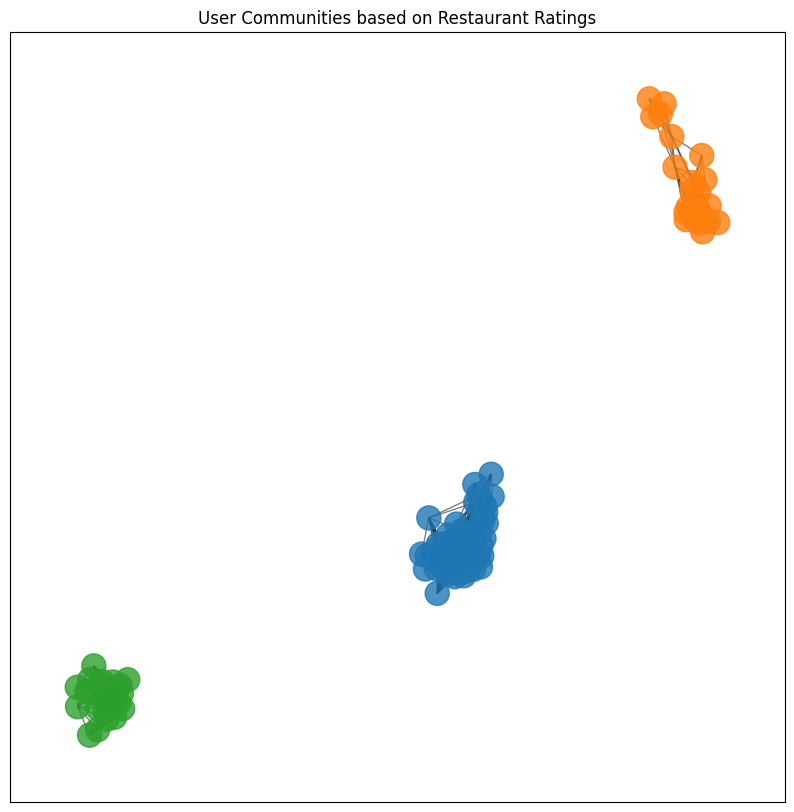

In [14]:
# Create a bipartite graph
B = nx.Graph()

# Add user nodes and restaurant nodes
B.add_nodes_from(users_with_cuisines['userID'], bipartite=0)  # Users
B.add_nodes_from(ratings['placeID'].unique(), bipartite=1)  # Restaurants

# Add edges based on ratings
for _, row in ratings.iterrows():
    B.add_edge(row['userID'], row['placeID'], rating=row['rating'], food_rating=row['food_rating'], service_rating=row['service_rating'])

# Since Spectral Clustering works on non-bipartite graphs, we'll use the projection of the user part
# Create user-user graph based on common restaurants rated
user_network = nx.bipartite.weighted_projected_graph(B, users_with_cuisines['userID'])

# Create the adjacency matrix from the user-user graph
adj_matrix = nx.to_numpy_array(user_network, nodelist=users_with_cuisines['userID'].tolist())

# Apply Spectral Clustering
n_clusters = 3
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0)
user_clusters = sc.fit_predict(adj_matrix)

# Map clusters back to users
users_with_cuisines['community'] = user_clusters

# Optional: Visualize the user communities
# This requires the 'community' attribute set from the clustering result
pos = nx.spring_layout(user_network)  # Positions for all nodes as per spring layout
community_colors = [f"C{community}" for community in user_clusters]  # Colors per community

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(user_network, pos, node_color=community_colors, alpha=0.8)
nx.draw_networkx_edges(user_network, pos, alpha=0.5)
plt.title('User Communities based on Restaurant Ratings')
plt.show()

In [15]:
import pandas as pd

# Assuming 'users' is your DataFrame and it includes 'community' column from your clustering

# Define the features we are interested in
features = ['drink_level','ambience','age_group','budget']

# Initialize an empty list to store community attributes data
community_list = []

# Loop through each community
for community in users_with_cuisines['community'].unique():
    community_data = users_with_cuisines[users_with_cuisines['community'] == community]  # Extract data for the current community
    # Calculate the most common value (mode) for each feature within the community
    attributes = {
        'community': community,
        'community_size': len(community_data)
    }
    for feature in features:
        mode_series = community_data[feature].mode()
        attributes[feature] = mode_series.iloc[0] if not mode_series.empty else 'Unknown'
    # Append the attributes of the current community to the list
    community_list.append(attributes)

# Create a DataFrame from the list
community_attributes = pd.DataFrame(community_list)

# Print the attributes of each community
print(community_attributes)

   community  community_size     drink_level ambience    age_group  budget
0          0              92  Social drinker   Family        Adult  Medium
1          1              23      Abstemious  Friends  Middle Aged  Medium
2          2              23      Abstemious   Family        Adult  Medium


We could assign each user a community on the basis of graph mining but as we can see that the some communities have <5 users hence it might not be very useful 

In [16]:
communities = users_with_cuisines[['userID','community']]

In [17]:
# Assigning the communities to the cleaned userprofile 
users_commmunities = pd.merge(users, communities, on='userID', how='left')

In [18]:
# Saving the csv files 
restaraunts_labels.to_csv("../data/clean/restaraunts_labels.csv")
users_commmunities.to_csv("../data/clean/users_commmunities.csv")